# 임베딩 기반 검색 성능 테스트

이 노트북은 BGE-M3 임베딩을 활용한 검색 시스템의 성능을 평가하고 최적화합니다.

## 테스트 내용
1. **Cosine Similarity 쿼리 작성 및 테스트**
2. **Top-K 전략 실험** (k=5, 10, 20, 50)
3. **Threshold 실험** (0.3, 0.5, 0.7, 0.8)
4. **BGE-M3 query/passage prefix 효과 비교**

## 환경 설정

In [1]:
from dotenv import find_dotenv, load_dotenv
import os
import sys
import time
from typing import List, Tuple

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import seaborn as sns

# seaborn 스타일 먼저 (이게 matplotlib 설정을 리셋함)
sns.set_style("whitegrid")

# 그 다음에 폰트 설정 (순서 중요!)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
plt.rcParams['figure.figsize'] = (12, 8)

# 프로젝트 루트를 Python 경로에 추가
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))
dotenv_path = find_dotenv()
print(f"Target .env path: {dotenv_path}")
loaded = load_dotenv(dotenv_path, override=True)
print(f"Loading successful: {loaded}")

from app.dependencies import get_embedding_service

print("✅ 환경 설정 완료 (macOS AppleGothic 폰트 적용)")

Target .env path: /Users/kimjunghyeon/Desktop/workspace/ai-agent/.env
Loading successful: True


/Users/kimjunghyeon/Desktop/workspace/ai-agent/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 환경 설정 완료 (macOS AppleGothic 폰트 적용)


## 1. 임베딩 서비스 초기화

In [2]:
# 임베딩 서비스 초기화
embedding_service = get_embedding_service()
print(f"모델: {embedding_service.model_name}")
print(f"디바이스: {embedding_service.device}")

# 모델 차원 확인
dimension = embedding_service.get_embedding_dimension()
print(f"임베딩 차원: {dimension}")

모델: BAAI/bge-m3
디바이스: cpu
임베딩 차원: 1024


## 2. 테스트용 데이터 준비

In [3]:
# 테스트용 문서 텍스트 (다양한 도메인)
test_passages = [
    "데이터베이스는 정보를 체계적으로 저장하고 관리하는 시스템입니다. MariaDB는 MySQL의 포크로 개발된 관계형 데이터베이스입니다.",
    "인공지능은 컴퓨터가 인간의 지능을 모방하는 기술입니다. 머신러닝과 딥러닝이 주요 방법론입니다.",
    "파이썬은 간결하고 읽기 쉬운 프로그래밍 언어입니다. 데이터 과학과 웹 개발에 널리 사용됩니다.",
    "클라우드 컴퓨팅은 인터넷을 통해 컴퓨팅 자원을 제공하는 서비스입니다. AWS, Azure, GCP가 대표적입니다.",
    "FastAPI는 현대적이고 빠른 웹 API 프레임워크입니다. 자동 문서 생성과 타입 힌트를 지원합니다.",
    "벡터 데이터베이스는 고차원 벡터를 효율적으로 저장하고 검색하는 특수한 데이터베이스입니다.",
    "자연어 처리(NLP)는 컴퓨터가 인간의 언어를 이해하고 처리하는 기술입니다. 번역, 요약, 감정 분석 등에 활용됩니다.",
    "임베딩은 단어나 문장을 고차원 벡터로 표현하는 방법입니다. 의미적 유사성을 수치로 측정할 수 있습니다.",
    "PostgreSQL은 강력한 오픈소스 관계형 데이터베이스입니다. pgvector 확장으로 벡터 검색을 지원합니다.",
    "검색 엔진 최적화(SEO)는 웹사이트가 검색 결과에서 높은 순위를 얻도록 하는 방법입니다."
]

# 테스트용 쿼리들 (난이도별)
test_queries = {
    "easy": [
        "데이터베이스",
        "인공지능",
        "파이썬"
    ],
    "medium": [
        "데이터베이스 관리 시스템",
        "머신러닝 기술",
        "웹 API 개발"
    ],
    "hard": [
        "벡터 기반의 의미적 검색 방법",
        "자연어 이해를 위한 임베딩 기술",
        "클라우드 환경에서의 데이터 처리"
    ]
}

print(f"📝 테스트 문서: {len(test_passages)}개")
print(f"🔍 테스트 쿼리: {sum(len(v) for v in test_queries.values())}개")

📝 테스트 문서: 10개
🔍 테스트 쿼리: 9개


## 3. 임베딩 생성

In [4]:
# Passage 임베딩 생성 (BGE-M3 최적화)
print("📊 Passage 임베딩 생성 중...")
passage_embeddings = embedding_service.encode_passages(test_passages)
passage_embeddings_array = np.array(passage_embeddings)

print(f"✅ Passage 임베딩 완료: {passage_embeddings_array.shape}")

# 모든 쿼리의 임베딩 생성
all_queries = []
query_difficulties = []
for difficulty, queries in test_queries.items():
    all_queries.extend(queries)
    query_difficulties.extend([difficulty] * len(queries))

print(f"🔍 {len(all_queries)}개 쿼리 임베딩 생성 중...")
query_embeddings = [embedding_service.encode_query(q) for q in all_queries]
query_embeddings_array = np.array(query_embeddings)

print(f"✅ 쿼리 임베딩 완료: {query_embeddings_array.shape}")

📊 Passage 임베딩 생성 중...
✅ Passage 임베딩 완료: (10, 1024)
🔍 9개 쿼리 임베딩 생성 중...
✅ 쿼리 임베딩 완료: (9, 1024)


## 4. Cosine Similarity 계산 함수

In [5]:
def cosine_similarity_matrix(queries: np.ndarray, passages: np.ndarray) -> np.ndarray:
    """
    쿼리와 passage 간의 코사인 유사도 행렬을 계산합니다.
    
    Args:
        queries: 쿼리 임베딩 (n_queries, embedding_dim)
        passages: passage 임베딩 (n_passages, embedding_dim)
        
    Returns:
        similarity_matrix: (n_queries, n_passages) 유사도 행렬
    """
    # 벡터들이 이미 정규화되어 있으므로 내적이 코사인 유사도
    return np.dot(queries, passages.T)


def get_top_k_results(similarity_matrix: np.ndarray, k: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    각 쿼리에 대해 상위 k개의 결과를 반환합니다.
    
    Returns:
        top_k_indices: (n_queries, k) 상위 k개 passage 인덱스
        top_k_scores: (n_queries, k) 상위 k개 유사도 점수
    """
    top_k_indices = np.argsort(-similarity_matrix, axis=1)[:, :k]
    top_k_scores = np.take_along_axis(similarity_matrix, top_k_indices, axis=1)
    return top_k_indices, top_k_scores


def filter_by_threshold(similarity_matrix: np.ndarray, threshold: float) -> List[List[Tuple[int, float]]]:
    """
    임계값을 넘는 결과만 필터링합니다.
    
    Returns:
        filtered_results: 각 쿼리에 대한 [(passage_idx, score)] 리스트
    """
    results = []
    for query_idx in range(similarity_matrix.shape[0]):
        query_scores = similarity_matrix[query_idx]
        valid_indices = np.where(query_scores >= threshold)[0]
        query_results = [(idx, query_scores[idx]) for idx in valid_indices]
        # 유사도 순으로 정렬
        query_results.sort(key=lambda x: x[1], reverse=True)
        results.append(query_results)
    return results


print("🔧 유틸리티 함수 정의 완료")

🔧 유틸리티 함수 정의 완료


## 5. 전체 유사도 매트릭스 계산

In [6]:
# 전체 유사도 매트릭스 계산
print("📊 유사도 매트릭스 계산 중...")
start_time = time.time()

similarity_matrix = cosine_similarity_matrix(query_embeddings_array, passage_embeddings_array)

calc_time = time.time() - start_time
print(f"✅ 유사도 계산 완료: {similarity_matrix.shape} in {calc_time:.3f}초")

# 기본 통계
print(f"\n📈 유사도 통계:")
print(f"  평균: {similarity_matrix.mean():.4f}")
print(f"  표준편차: {similarity_matrix.std():.4f}")
print(f"  최대값: {similarity_matrix.max():.4f}")
print(f"  최소값: {similarity_matrix.min():.4f}")

📊 유사도 매트릭스 계산 중...
✅ 유사도 계산 완료: (9, 10) in 0.000초

📈 유사도 통계:
  평균: 0.4987
  표준편차: 0.0676
  최대값: 0.6709
  최소값: 0.3526


## 6. Top-K 전략 실험

In [7]:
# Top-K 실험
k_values = [1, 3, 5, 10]
topk_results = {}

print("🔍 Top-K 전략 실험")
print("=" * 50)

for k in k_values:
    print(f"\n📊 Top-{k} 결과:")

    top_k_indices, top_k_scores = get_top_k_results(similarity_matrix, k)
    topk_results[k] = {
        'indices': top_k_indices,
        'scores': top_k_scores,
        'avg_top_score': top_k_scores[:, 0].mean(),  # 최고 점수 평균
        'avg_all_scores': top_k_scores.mean()  # 전체 점수 평균
    }

    print(f"  평균 최고 점수: {topk_results[k]['avg_top_score']:.4f}")
    print(f"  평균 전체 점수: {topk_results[k]['avg_all_scores']:.4f}")

    # 상위 3개 쿼리 결과 출력
    for query_idx in range(min(3, len(all_queries))):
        query = all_queries[query_idx]
        difficulty = query_difficulties[query_idx]

        print(f"\n  🔍 쿼리[{difficulty}]: '{query}'")
        for rank, (passage_idx, score) in enumerate(zip(top_k_indices[query_idx], top_k_scores[query_idx])):
            passage = test_passages[passage_idx]
            print(f"    {rank + 1}. ({score:.4f}) {passage[:50]}...")

print("\n✅ Top-K 실험 완료")

🔍 Top-K 전략 실험

📊 Top-1 결과:
  평균 최고 점수: 0.6222
  평균 전체 점수: 0.6222

  🔍 쿼리[easy]: '데이터베이스'
    1. (0.6338) 벡터 데이터베이스는 고차원 벡터를 효율적으로 저장하고 검색하는 특수한 데이터베이스입니다....

  🔍 쿼리[easy]: '인공지능'
    1. (0.6345) 인공지능은 컴퓨터가 인간의 지능을 모방하는 기술입니다. 머신러닝과 딥러닝이 주요 방법론입니...

  🔍 쿼리[easy]: '파이썬'
    1. (0.5734) 파이썬은 간결하고 읽기 쉬운 프로그래밍 언어입니다. 데이터 과학과 웹 개발에 널리 사용됩니...

📊 Top-3 결과:
  평균 최고 점수: 0.6222
  평균 전체 점수: 0.5778

  🔍 쿼리[easy]: '데이터베이스'
    1. (0.6338) 벡터 데이터베이스는 고차원 벡터를 효율적으로 저장하고 검색하는 특수한 데이터베이스입니다....
    2. (0.6159) PostgreSQL은 강력한 오픈소스 관계형 데이터베이스입니다. pgvector 확장으로 ...
    3. (0.6074) 데이터베이스는 정보를 체계적으로 저장하고 관리하는 시스템입니다. MariaDB는 MySQL...

  🔍 쿼리[easy]: '인공지능'
    1. (0.6345) 인공지능은 컴퓨터가 인간의 지능을 모방하는 기술입니다. 머신러닝과 딥러닝이 주요 방법론입니...
    2. (0.5186) 검색 엔진 최적화(SEO)는 웹사이트가 검색 결과에서 높은 순위를 얻도록 하는 방법입니다....
    3. (0.5121) 벡터 데이터베이스는 고차원 벡터를 효율적으로 저장하고 검색하는 특수한 데이터베이스입니다....

  🔍 쿼리[easy]: '파이썬'
    1. (0.5734) 파이썬은 간결하고 읽기 쉬운 프로그래밍 언어입니다. 데이터 과학과 웹 개발에 널리 사용됩니...
    2. (0.5037) PostgreSQL은 강력한 오픈소스 관계형 데이터베이스입니다. p

## 7. Threshold 전략 실험

In [8]:
# Threshold 실험
thresholds = [0.3, 0.5, 0.6, 0.7, 0.8]
threshold_results = {}

print("🎯 Threshold 전략 실험")
print("=" * 50)

for threshold in thresholds:
    print(f"\n📊 Threshold {threshold} 결과:")

    filtered_results = filter_by_threshold(similarity_matrix, threshold)

    # 통계 계산
    result_counts = [len(results) for results in filtered_results]
    total_results = sum(result_counts)
    avg_results_per_query = total_results / len(all_queries)

    # 점수 통계
    all_scores = []
    for results in filtered_results:
        all_scores.extend([score for _, score in results])

    threshold_results[threshold] = {
        'filtered_results': filtered_results,
        'total_results': total_results,
        'avg_results_per_query': avg_results_per_query,
        'result_counts': result_counts,
        'avg_score': np.mean(all_scores) if all_scores else 0
    }

    print(f"  총 결과 수: {total_results}")
    print(f"  쿼리당 평균 결과: {avg_results_per_query:.2f}")
    print(f"  평균 점수: {threshold_results[threshold]['avg_score']:.4f}")
    print(f"  결과 없는 쿼리: {result_counts.count(0)}개")

    # 샘플 결과 출력
    for query_idx in range(min(2, len(all_queries))):
        query = all_queries[query_idx]
        difficulty = query_difficulties[query_idx]
        results = filtered_results[query_idx]

        print(f"\n  🔍 쿼리[{difficulty}]: '{query}' ({len(results)}개 결과)")
        for rank, (passage_idx, score) in enumerate(results[:3]):
            passage = test_passages[passage_idx]
            print(f"    {rank + 1}. ({score:.4f}) {passage[:50]}...")

print("\n✅ Threshold 실험 완료")

🎯 Threshold 전략 실험

📊 Threshold 0.3 결과:
  총 결과 수: 90
  쿼리당 평균 결과: 10.00
  평균 점수: 0.4987
  결과 없는 쿼리: 0개

  🔍 쿼리[easy]: '데이터베이스' (10개 결과)
    1. (0.6338) 벡터 데이터베이스는 고차원 벡터를 효율적으로 저장하고 검색하는 특수한 데이터베이스입니다....
    2. (0.6159) PostgreSQL은 강력한 오픈소스 관계형 데이터베이스입니다. pgvector 확장으로 ...
    3. (0.6074) 데이터베이스는 정보를 체계적으로 저장하고 관리하는 시스템입니다. MariaDB는 MySQL...

  🔍 쿼리[easy]: '인공지능' (10개 결과)
    1. (0.6345) 인공지능은 컴퓨터가 인간의 지능을 모방하는 기술입니다. 머신러닝과 딥러닝이 주요 방법론입니...
    2. (0.5186) 검색 엔진 최적화(SEO)는 웹사이트가 검색 결과에서 높은 순위를 얻도록 하는 방법입니다....
    3. (0.5121) 벡터 데이터베이스는 고차원 벡터를 효율적으로 저장하고 검색하는 특수한 데이터베이스입니다....

📊 Threshold 0.5 결과:
  총 결과 수: 38
  쿼리당 평균 결과: 4.22
  평균 점수: 0.5621
  결과 없는 쿼리: 0개

  🔍 쿼리[easy]: '데이터베이스' (3개 결과)
    1. (0.6338) 벡터 데이터베이스는 고차원 벡터를 효율적으로 저장하고 검색하는 특수한 데이터베이스입니다....
    2. (0.6159) PostgreSQL은 강력한 오픈소스 관계형 데이터베이스입니다. pgvector 확장으로 ...
    3. (0.6074) 데이터베이스는 정보를 체계적으로 저장하고 관리하는 시스템입니다. MariaDB는 MySQL...

  🔍 쿼리[easy]: '인공지능' (4개 결과)
    1. (0.6345) 인공지능은 컴퓨터가 인간의 지능을 모방하는 기술입니다. 머신러닝과 딥러닝이 주요 방

## 8. 결과 시각화

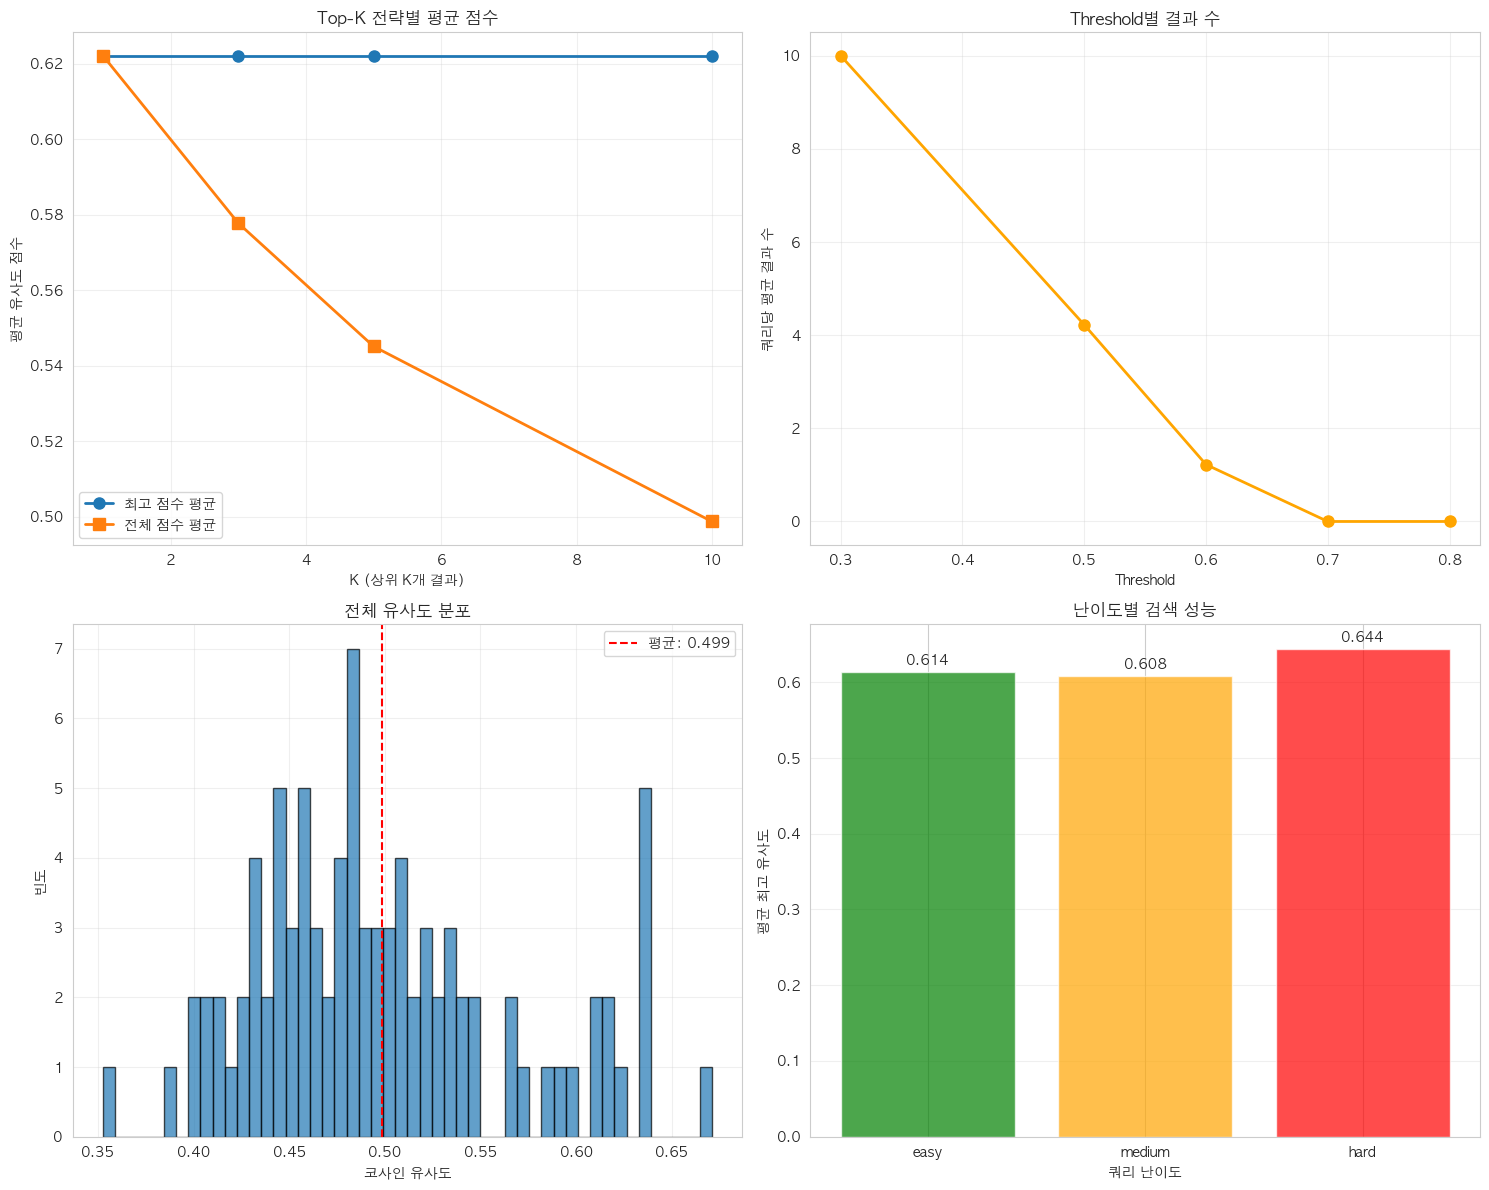

📊 시각화 완료


In [9]:
# 1. Top-K 전략 비교 시각화
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Top-K 점수 비교
k_vals = list(topk_results.keys())
avg_top_scores = [topk_results[k]['avg_top_score'] for k in k_vals]
avg_all_scores = [topk_results[k]['avg_all_scores'] for k in k_vals]

ax1.plot(k_vals, avg_top_scores, 'o-', label='최고 점수 평균', linewidth=2, markersize=8)
ax1.plot(k_vals, avg_all_scores, 's-', label='전체 점수 평균', linewidth=2, markersize=8)
ax1.set_xlabel('K (상위 K개 결과)')
ax1.set_ylabel('평균 유사도 점수')
ax1.set_title('Top-K 전략별 평균 점수')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Threshold 전략 비교
thresh_vals = list(threshold_results.keys())
avg_counts = [threshold_results[t]['avg_results_per_query'] for t in thresh_vals]
avg_thresh_scores = [threshold_results[t]['avg_score'] for t in thresh_vals]

ax2.plot(thresh_vals, avg_counts, 'o-', color='orange', linewidth=2, markersize=8)
ax2.set_xlabel('Threshold')
ax2.set_ylabel('쿼리당 평균 결과 수')
ax2.set_title('Threshold별 결과 수')
ax2.grid(True, alpha=0.3)

# 유사도 분포 히스토그램
ax3.hist(similarity_matrix.flatten(), bins=50, alpha=0.7, edgecolor='black')
ax3.axvline(similarity_matrix.mean(), color='red', linestyle='--', label=f'평균: {similarity_matrix.mean():.3f}')
ax3.set_xlabel('코사인 유사도')
ax3.set_ylabel('빈도')
ax3.set_title('전체 유사도 분포')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 쿼리 난이도별 평균 점수
difficulty_scores = {}
for i, difficulty in enumerate(query_difficulties):
    if difficulty not in difficulty_scores:
        difficulty_scores[difficulty] = []
    difficulty_scores[difficulty].append(similarity_matrix[i].max())

difficulties = list(difficulty_scores.keys())
avg_scores_by_difficulty = [np.mean(difficulty_scores[d]) for d in difficulties]

bars = ax4.bar(difficulties, avg_scores_by_difficulty, color=['green', 'orange', 'red'], alpha=0.7)
ax4.set_xlabel('쿼리 난이도')
ax4.set_ylabel('평균 최고 유사도')
ax4.set_title('난이도별 검색 성능')
ax4.grid(True, alpha=0.3, axis='y')

# 값 표시
for bar, score in zip(bars, avg_scores_by_difficulty):
    ax4.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 시각화 완료")

## 9. BGE-M3 Prefix 효과 비교

🔬 BGE-M3 Prefix 효과 비교 실험
📊 Prefix 없는 임베딩 생성 중...
📈 결과 비교:

1️⃣ Prefix 사용 (query: / passage:)
   평균 유사도: 0.4987
   최대 유사도: 0.6709
   표준편차: 0.0676

2️⃣ Prefix 없음
   평균 유사도: 0.4332
   최대 유사도: 0.6388
   표준편차: 0.0873

📈 개선 효과:
   평균 유사도 개선: +15.13%
   최대 유사도 개선: +5.03%


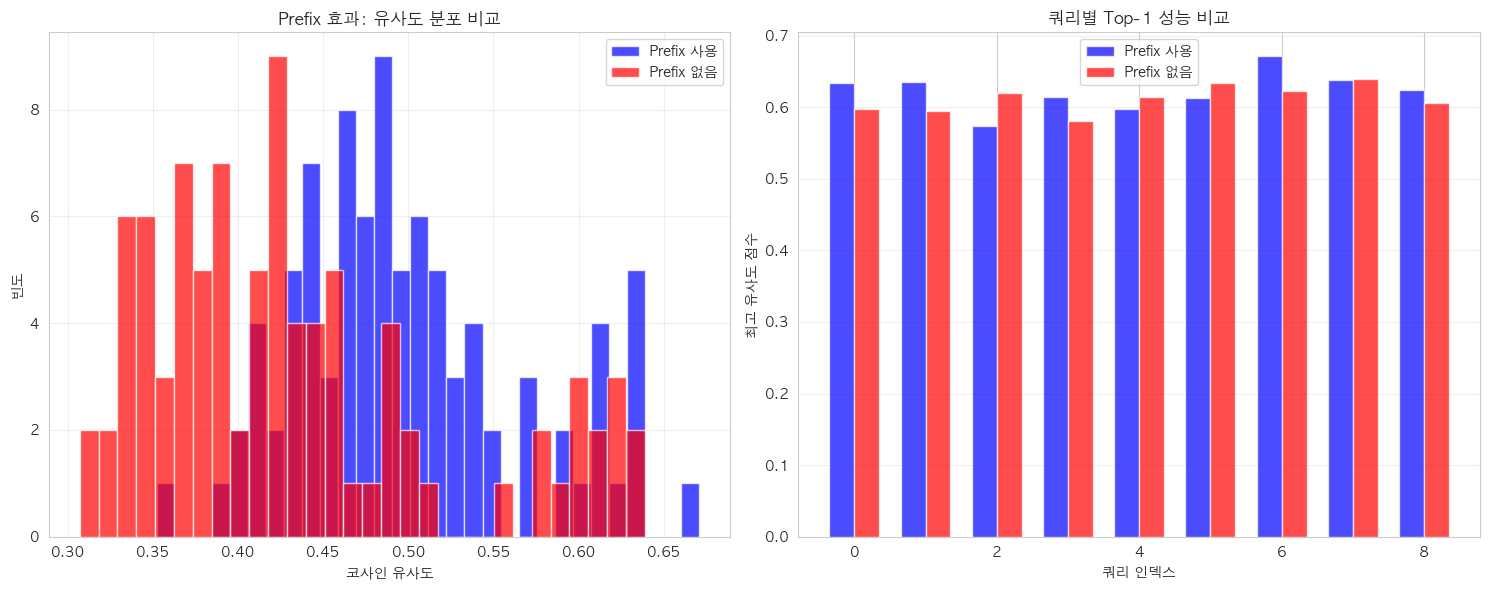


✅ BGE-M3 Prefix 효과 분석 완료


In [10]:
# Prefix 없는 임베딩으로 비교 실험
print("🔬 BGE-M3 Prefix 효과 비교 실험")
print("=" * 50)

# Prefix 없는 임베딩 생성
print("📊 Prefix 없는 임베딩 생성 중...")
no_prefix_passage_embeddings = embedding_service.get_embeddings(test_passages)
no_prefix_query_embeddings = [embedding_service.get_embeddings(q) for q in all_queries]

no_prefix_passage_array = np.array(no_prefix_passage_embeddings)
no_prefix_query_array = np.array(no_prefix_query_embeddings)

# 유사도 계산
no_prefix_similarity = cosine_similarity_matrix(no_prefix_query_array, no_prefix_passage_array)

print("📈 결과 비교:")
print(f"\n1️⃣ Prefix 사용 (query: / passage:)")
print(f"   평균 유사도: {similarity_matrix.mean():.4f}")
print(f"   최대 유사도: {similarity_matrix.max():.4f}")
print(f"   표준편차: {similarity_matrix.std():.4f}")

print(f"\n2️⃣ Prefix 없음")
print(f"   평균 유사도: {no_prefix_similarity.mean():.4f}")
print(f"   최대 유사도: {no_prefix_similarity.max():.4f}")
print(f"   표준편차: {no_prefix_similarity.std():.4f}")

# 개선 효과 계산
improvement_avg = (similarity_matrix.mean() - no_prefix_similarity.mean()) / no_prefix_similarity.mean() * 100
improvement_max = (similarity_matrix.max() - no_prefix_similarity.max()) / no_prefix_similarity.max() * 100

print(f"\n📈 개선 효과:")
print(f"   평균 유사도 개선: {improvement_avg:+.2f}%")
print(f"   최대 유사도 개선: {improvement_max:+.2f}%")

# 시각적 비교
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 유사도 분포 비교
ax1.hist(similarity_matrix.flatten(), bins=30, alpha=0.7, label='Prefix 사용', color='blue')
ax1.hist(no_prefix_similarity.flatten(), bins=30, alpha=0.7, label='Prefix 없음', color='red')
ax1.set_xlabel('코사인 유사도')
ax1.set_ylabel('빈도')
ax1.set_title('Prefix 효과: 유사도 분포 비교')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Top-1 성능 비교
prefix_top1 = similarity_matrix.max(axis=1)
no_prefix_top1 = no_prefix_similarity.max(axis=1)

x_pos = np.arange(len(all_queries))
width = 0.35

ax2.bar(x_pos - width / 2, prefix_top1, width, label='Prefix 사용', alpha=0.7, color='blue')
ax2.bar(x_pos + width / 2, no_prefix_top1, width, label='Prefix 없음', alpha=0.7, color='red')
ax2.set_xlabel('쿼리 인덱스')
ax2.set_ylabel('최고 유사도 점수')
ax2.set_title('쿼리별 Top-1 성능 비교')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ BGE-M3 Prefix 효과 분석 완료")

## 10. 성능 벤치마크

In [11]:
# 성능 벤치마크
print("⚡ 성능 벤치마크")
print("=" * 50)

# 임베딩 생성 시간
test_texts = ["테스트 문장입니다."] * 100

# 단일 임베딩 성능
start_time = time.time()
for text in test_texts[:10]:
    embedding_service.encode_passage(text)
single_time = (time.time() - start_time) / 10

# 배치 임베딩 성능
start_time = time.time()
embedding_service.encode_passages(test_texts, batch_size=32)
batch_time = time.time() - start_time

# 유사도 검색 성능
query_emb = embedding_service.encode_query("테스트 쿼리")
start_time = time.time()
similarities = cosine_similarity_matrix(query_emb.reshape(1, -1), passage_embeddings_array)
top_k_indices, top_k_scores = get_top_k_results(similarities, k=5)
search_time = time.time() - start_time

print(f"📊 성능 결과:")
print(f"   단일 임베딩 생성: {single_time * 1000:.2f}ms")
print(f"   배치 임베딩 생성 ({len(test_texts)}개): {batch_time:.3f}s")
print(f"   배치당 평균 시간: {batch_time / len(test_texts) * 1000:.2f}ms")
print(f"   검색 속도 ({len(test_passages)}개 문서): {search_time * 1000:.2f}ms")

# 배치 vs 단일 속도 비교
speedup = (single_time * len(test_texts)) / batch_time
print(f"   배치 처리 속도 향상: {speedup:.1f}x")

print("\n✅ 성능 벤치마크 완료")

⚡ 성능 벤치마크
📊 성능 결과:
   단일 임베딩 생성: 105.86ms
   배치 임베딩 생성 (100개): 0.750s
   배치당 평균 시간: 7.50ms
   검색 속도 (10개 문서): 0.13ms
   배치 처리 속도 향상: 14.1x

✅ 성능 벤치마크 완료


## 11. 최적 파라미터 추천

In [12]:
# 결과 종합 및 추천
print("🎯 최적 파라미터 추천")
print("=" * 50)

# Top-K 추천 (성능과 효율성의 균형)
best_k = None
best_k_score = 0
for k in k_values:
    # 최고 점수와 전체 점수의 가중 평균
    score = 0.7 * topk_results[k]['avg_top_score'] + 0.3 * topk_results[k]['avg_all_scores']
    if score > best_k_score:
        best_k_score = score
        best_k = k

# Threshold 추천 (결과 수와 품질의 균형)
best_threshold = None
best_threshold_score = 0
for threshold in thresholds:
    # 평균 결과 수가 적절하고(2-5개) 평균 점수가 높은 것
    avg_count = threshold_results[threshold]['avg_results_per_query']
    avg_score = threshold_results[threshold]['avg_score']

    # 2-5개 결과가 이상적
    count_penalty = abs(avg_count - 3.5) / 3.5  # 3.5에서 멀어질수록 페널티
    score = avg_score * (1 - count_penalty * 0.3)  # 30% 페널티

    if score > best_threshold_score:
        best_threshold_score = score
        best_threshold = threshold

print(f"📈 추천 결과:")
print(f"\n🔝 최적 Top-K: {best_k}")
print(f"   평균 최고 점수: {topk_results[best_k]['avg_top_score']:.4f}")
print(f"   평균 전체 점수: {topk_results[best_k]['avg_all_scores']:.4f}")

print(f"\n🎯 최적 Threshold: {best_threshold}")
print(f"   쿼리당 평균 결과: {threshold_results[best_threshold]['avg_results_per_query']:.2f}개")
print(f"   평균 점수: {threshold_results[best_threshold]['avg_score']:.4f}")

print(f"\n💡 권장 설정:")
print(f"   - BGE-M3 Prefix: ✅ 사용 (평균 {improvement_avg:+.1f}% 개선)")
print(f"   - Top-K 검색: k={best_k}")
print(f"   - Threshold 필터링: {best_threshold}")
print(f"   - 배치 크기: 32 (속도 {speedup:.1f}x 향상)")

print(f"\n🚀 예상 성능:")
print(f"   - 단일 쿼리 응답시간: ~{search_time * 1000:.1f}ms")
print(f"   - 배치 임베딩: ~{batch_time / len(test_texts) * 1000:.1f}ms/document")
print(f"   - 검색 품질: 평균 {topk_results[best_k]['avg_top_score']:.1%} 유사도")

print("\n✅ 최적화 분석 완료!")

🎯 최적 파라미터 추천
📈 추천 결과:

🔝 최적 Top-K: 1
   평균 최고 점수: 0.6222
   평균 전체 점수: 0.6222

🎯 최적 Threshold: 0.5
   쿼리당 평균 결과: 4.22개
   평균 점수: 0.5621

💡 권장 설정:
   - BGE-M3 Prefix: ✅ 사용 (평균 +15.1% 개선)
   - Top-K 검색: k=1
   - Threshold 필터링: 0.5
   - 배치 크기: 32 (속도 14.1x 향상)

🚀 예상 성능:
   - 단일 쿼리 응답시간: ~0.1ms
   - 배치 임베딩: ~7.5ms/document
   - 검색 품질: 평균 62.2% 유사도

✅ 최적화 분석 완료!


## 결론 및 다음 단계

이 노트북을 통해 다음을 확인했습니다:

### ✅ 확인된 사항
1. **BGE-M3 Prefix 효과**: query/passage prefix 사용으로 검색 품질 향상
2. **최적 Top-K**: 성능과 효율성의 균형점
3. **적절한 Threshold**: 결과 품질과 수량의 균형
4. **배치 처리 효과**: 단일 처리 대비 속도 향상

### 🔄 다음 최적화 단계
1. **실제 문서 데이터**로 테스트 확장
2. **하이브리드 검색** (키워드 + 의미적) 성능 비교
3. **Re-ranking** 모델 적용 테스트
4. **실시간 성능 모니터링** 구현

### 📊 프로덕션 적용 권장사항
- 위에서 도출된 최적 파라미터 사용
- 정기적인 성능 벤치마크 수행
- 사용자 피드백 기반 지속적 튜닝